In [6]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import sem, linregress, pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np

In [7]:
# Study data files
mouse_metadata_path = "./data/Mouse_metadata.csv"
study_results_path = "./data/Study_results.csv"

In [8]:
# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

In [9]:
# Combine the data into a single DataFrame
df= pd.merge(study_results, mouse_metadata, on='Mouse ID', how='inner')
df5= df.copy()
# Display the data table for preview
df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22
...,...,...,...,...,...,...,...,...
1888,m601,25,33.118756,1,Capomulin,Male,22,17
1889,m601,30,31.758275,1,Capomulin,Male,22,17
1890,m601,35,30.834357,1,Capomulin,Male,22,17
1891,m601,40,31.378045,1,Capomulin,Male,22,17


In [10]:
# Checking the number of mice.
df['Mouse ID'].nunique()

249

In [11]:
# Our data should be uniquely identified by Mouse ID and Timepoint
# Get the duplicate mice by ID number that shows up for Mouse ID and Timepoint.
df1=df[df.duplicated(subset=['Mouse ID', 'Timepoint'], keep=False )].copy()
df1.groupby('Mouse ID')['Timepoint'].unique()

Mouse ID
g989    [0, 5, 10, 15, 20]
Name: Timepoint, dtype: object

In [12]:
# Optional: Get all the data for the duplicate mouse ID. 
# Optional: Get all the data for the duplicate mouse ID. 
data_frame2=df[df['Mouse ID'] == 'g989']
data_frame2

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
860,g989,0,45.000000,0,Propriva,Female,21,26
861,g989,0,45.000000,0,Propriva,Female,21,26
862,g989,5,48.786801,0,Propriva,Female,21,26
863,g989,5,47.570392,0,Propriva,Female,21,26
864,g989,10,51.745156,0,Propriva,Female,21,26
865,g989,10,49.880528,0,Propriva,Female,21,26
866,g989,15,51.325852,1,Propriva,Female,21,26
867,g989,15,53.442020,0,Propriva,Female,21,26
868,g989,20,55.326122,1,Propriva,Female,21,26
869,g989,20,54.657650,1,Propriva,Female,21,26


In [13]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
data_frame2= data_frame2.iloc[1:]
# Perform a left anti-join (drop merge)
df = pd.merge(df, data_frame2, on=['Mouse ID'], how='left', indicator=True)
df = df[df['_merge'] == 'left_only']

# Drop the indicator column
df.drop(columns=['_merge'], inplace=True)

In [14]:
df3 = df.copy() 
for i in range(8):
    df3.columns.values[i] = data_frame2.columns.values[i]
ctd=df3.columns[8:15]
df = df3.drop(columns=ctd)
df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22
...,...,...,...,...,...,...,...,...
2031,m601,25,33.118756,1,Capomulin,Male,22,17
2032,m601,30,31.758275,1,Capomulin,Male,22,17
2033,m601,35,30.834357,1,Capomulin,Male,22,17
2034,m601,40,31.378045,1,Capomulin,Male,22,17


In [15]:
# Checking the number of mice in the clean DataFrame.
df['Mouse ID'].nunique()

248

## Summary Statistics

In [16]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
agg_dict = {
    'Tumor Volume (mm3)': ['mean', 'median', 'var', 'std', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))]
}
# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary DataFrame.
data_frame2 = df.groupby('Drug Regimen').agg(agg_dict).reset_index()

# Rename the columns
data_frame2.columns = ['Drug Regimen', 'Mean Tumor Volume', 'Median Tumor Volume', 'Tumor Volume Variance', 'Tumor Volume Std. Dev.', 'Tumor Volume Std. Err.']
data_frame2


,Drug Regimen,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
0,Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
1,Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
2,Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
3,Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
4,Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
5,Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
6,Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
7,Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
8,Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111
9,Zoniferol,53.236507,51.818479,48.533355,6.966589,0.516398


In [17]:
# A more advanced method to generate a summary statistics table of mean, median, variance, standard deviation,
# and SEM of the tumor volume for each regimen (only one method is required in the solution)
data_frame2 = df.groupby('Drug Regimen').agg({'Tumor Volume (mm3)': ['mean', 'median', 'var', 'std', 'sem']})#.reset_index()

# Using the aggregation method, produce the same summary statistics in a single line
data_frame2

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

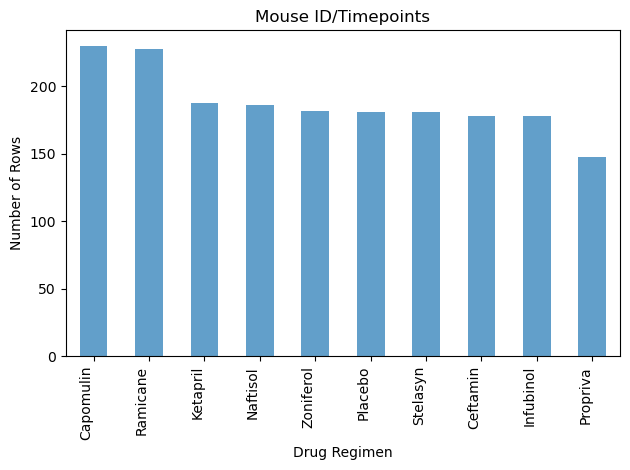

In [18]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using Pandas.
drug_count = df.groupby('Drug Regimen').size().sort_values(ascending=False)

# Create a bar plot using pandas plotting
drug_count.plot(kind='bar', alpha=0.7)
plt.title('Mouse ID/Timepoints')
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Rows')
plt.xticks(ha='right')
plt.tight_layout()
plt.show()

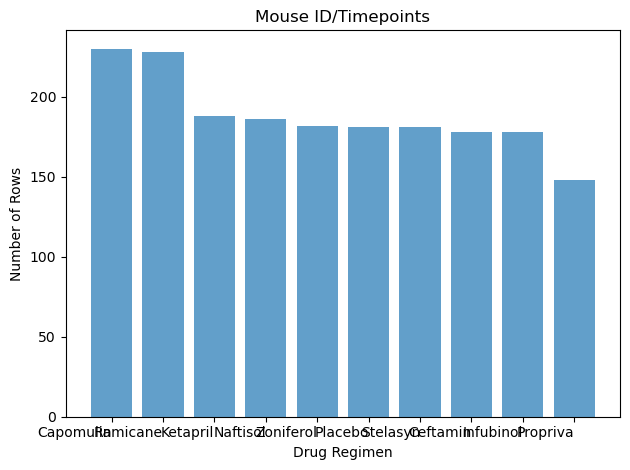

In [19]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using pyplot.
drug_count = df.groupby('Drug Regimen').size().sort_values(ascending=False)

# Create a bar plot using pyplot
plt.bar(drug_count.index, drug_count.values, alpha=0.7)
plt.title('Mouse ID/Timepoints')
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Rows')
plt.xticks(ha='right')
plt.tight_layout()
plt.show()

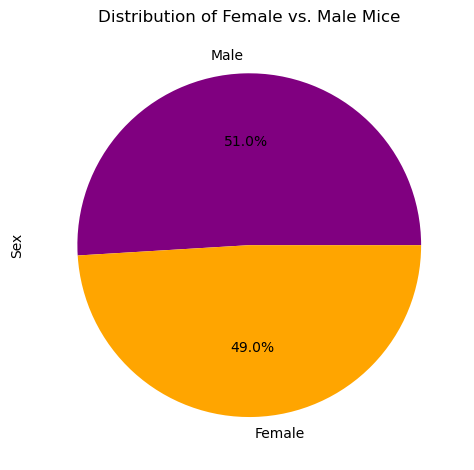

In [20]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas
sex_count = df['Sex'].value_counts()

# Create a pie plot using pandas plotting
sex_count.plot(kind='pie', autopct='%1.1f%%' ,colors=['purple', 'orange'] )
plt.title('Distribution of Female vs. Male Mice')
plt.ylabel('Sex')  # Remove the 'Sex' label on the y-axis
plt.tight_layout()
plt.show()

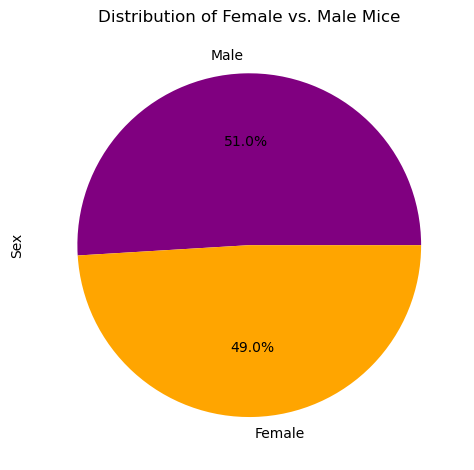

In [21]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
sex_count = df['Sex'].value_counts()

# Create a pie plot using pyplot
plt.pie(sex_count, labels=sex_count.index, autopct='%1.1f%%',colors=['purple', 'orange'] )
plt.title('Distribution of Female vs. Male Mice')
plt.ylabel('Sex')  # Set y-axis label
plt.tight_layout()
plt.show()

## Quartiles, Outliers and Boxplots

In [22]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin
treatment_regimens = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']
data_frame2 = df[df['Drug Regimen'].isin(treatment_regimens)]

# Get the last (greatest) timepoint for each mouse
df3 = data_frame2.groupby('Mouse ID')['Timepoint'].max()

# Merge the last timepoints with the original DataFrame to get the final tumor volume
df4 = pd.merge(df, df3, on=['Mouse ID', 'Timepoint'])
df4

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,45,38.982878,2,Capomulin,Female,9,22
1,c326,5,36.321346,0,Infubinol,Female,18,25
2,c139,45,72.226731,2,Infubinol,Male,11,28
3,v339,5,46.250112,0,Infubinol,Male,20,26
4,a577,30,57.031862,2,Infubinol,Female,6,25
...,...,...,...,...,...,...,...,...
95,t565,45,34.455298,0,Capomulin,Female,20,17
96,i557,45,47.685963,1,Capomulin,Female,1,24
97,m957,45,33.329098,1,Capomulin,Female,3,19
98,f966,20,30.485985,0,Capomulin,Male,16,17


<Figure size 800x600 with 0 Axes>

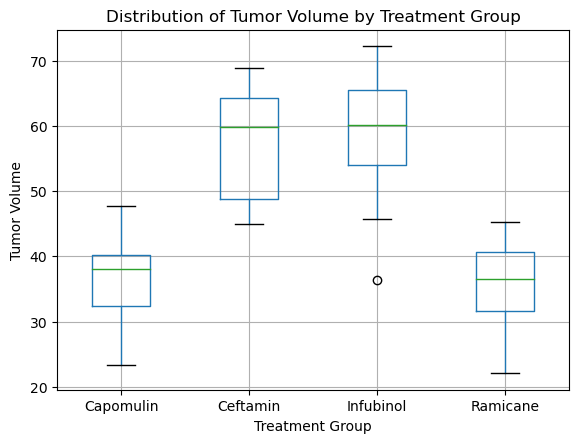

In [23]:
# Generate a box plot that shows the distrubution of the tumor volume for each treatment group.
plt.figure(figsize=(8, 6))
df4.boxplot(column="Tumor Volume (mm3)", by="Drug Regimen")
plt.xlabel("Treatment Group")
plt.ylabel("Tumor Volume")
plt.title("Distribution of Tumor Volume by Treatment Group")
plt.suptitle("")  # Remove default title from boxplot
plt.show()

## Line and Scatter Plots

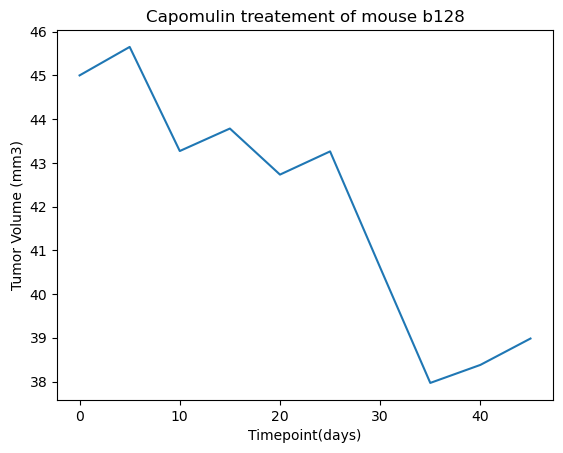

In [24]:
# Generate a line plot of tumor volume vs. time point for a single mouse treated with Capomulin
data_frame2 = df5.loc[df5['Mouse ID'] == 'b128']

x_axis = data_frame2['Timepoint']
y_values = data_frame2['Tumor Volume (mm3)']
plt.plot(x_axis,y_values, label='Tumor Volume (mm3)')
plt.xlabel('Timepoint(days)')
plt.ylabel('Tumor Volume (mm3)')
plt.title('Capomulin treatement of mouse b128')
plt.show()

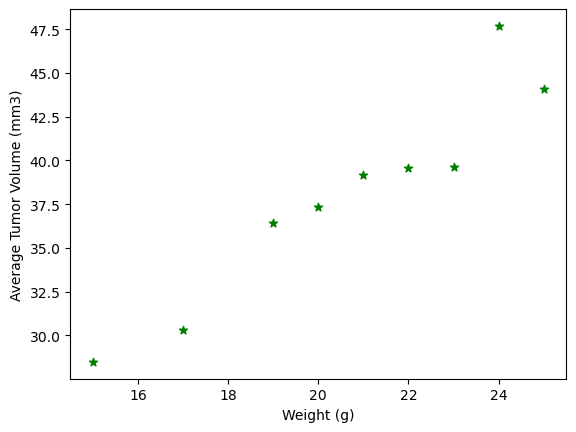

In [25]:
# Generate a scatter plot of mouse weight vs. the average observed tumor volume for the entire Capomulin regimen
data_frame2 = df4.loc[(df4['Drug Regimen']=='Capomulin')]
df3 = data_frame2.groupby(['Weight (g)'])[['Tumor Volume (mm3)']].mean()

x_axis = df3.index
y_values = df3['Tumor Volume (mm3)']
plt.scatter(x_axis,y_values, label='Tumor Volume (mm3)', marker='*', color='green')
plt.xlabel('Weight (g)')
plt.ylabel('Average Tumor Volume (mm3)')
plt.show()

The correlation between mouse weight and the average tumor volume is  0.9649139542110665


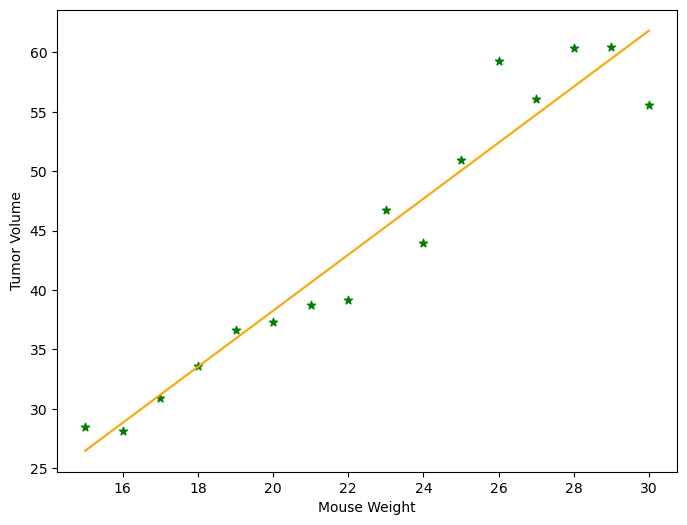

In [30]:
##Correlation & Regression






# Calculate the correlation coefficient and a linear regression model 
# for mouse weight and average observed tumor volume for the entire Capomulin regimen


df6 = df4.groupby("Weight (g)")["Tumor Volume (mm3)"].mean().reset_index()
df6.columns = ["Mouse_Weight", "Avg_Tumor_Volume"]

correlation_coefficient, _ = pearsonr(df6["Mouse_Weight"], df6["Avg_Tumor_Volume"])
print("The correlation between mouse weight and the average tumor volume is ", correlation_coefficient)

regressor = LinearRegression()
X = df6[["Mouse_Weight"]]           
y = df6["Avg_Tumor_Volume"]             
regressor.fit(X, y)

slope = regressor.coef_[0]
intercept = regressor.intercept_

plt.figure(figsize=(8, 6))
plt.scatter(df6["Mouse_Weight"], df6["Avg_Tumor_Volume"], label="Data Points", marker='*', color='green')
plt.plot(df6["Mouse_Weight"], regressor.predict(X), color='orange', label="Regression Line")
plt.xlabel("Mouse Weight")
plt.ylabel("Tumor Volume")


# plt.title("Mouse Weight vs. Tumor Volume")
# plt.legend()
# plt.grid(True)
plt.show()